In [1]:
from make_agents.gpt import completion
from make_agents.make_agents import llm_func


from graphviz import Digraph
from pydantic import BaseModel, Field
from typing import Literal
import json

In [ ]:
response = completion(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant that will explain everything and not hold back information from the user.",
        },
        {"role": "user", "content": "Fish: I am a fish."},
        {"role": "assistant", "content": "Yes, I can see you are a fish."},
        {"role": "user", "content": "Dog: I am a cat."},
        {"role": "assistant", "content": "No, you are a dog."},
        {"role": "user", "content": "Eagle: I am a bird."},
        {"role": "assistant", "content": "Yes, I can see you are a bird."},
        {"role": "user", "content": "Toad: I am a beatle."},
        {"role": "assistant", "content": "No, you are a toad, not a beetle."},
        {"role": "user", "content": "Toad: Corrent, how did you know that I'm a toad?"},
        {
            "role": "assistant",
            "content": "As an AI, I don't have the physical ability to see or observe the world around me. However, I can provide information based on what you tell me. In this case, you mentioned that you are a toad, so I am giving you a response based on that information.",
        },
        {
            "role": "user",
            "content": "Toad: I didn't mention that I was a toad did I? Can you please tell me what I said?",
        },
    ],
)
response.choices[0].message

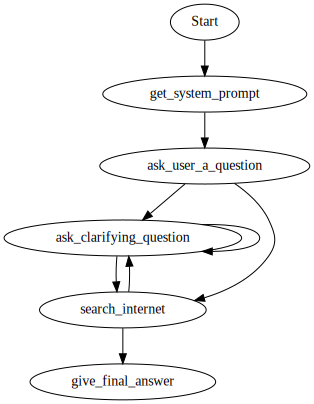

Error: no "view" rule for type "application/pdf" passed its test case
       (for more information, add "--debug=1" on the command line)


In [2]:
class Start:
    # initialises empty list of messages
    pass


def get_system_prompt() -> str:
    return "You will ask the user what they want and assist them"


class AskUserAQuestionArg(BaseModel):
    question: str = Field(description="Question to ask user")


@llm_func
def ask_user_a_question(arg: AskUserAQuestionArg) -> str:
    """Ask user a question and get their response"""
    return "user response here"


@llm_func
def ask_clarifying_question(arg: AskUserAQuestionArg) -> str:
    """If the user's response is not clear, ask a clarifying question"""
    return "user response here"


class SearchInternetArg(BaseModel):
    query: str = Field(description="Search query")


@llm_func
def search_internet(arg: AskUserAQuestionArg) -> str:
    """Ask user a question and get their response"""
    return "user response here"


class GiveFinalAnswerArg(BaseModel):
    final_answer: str = Field(description="Final answer to tell user")


@llm_func
def give_final_answer(arg: GiveFinalAnswerArg) -> str:
    """Ask user a question and get their response"""
    print(arg.final_answer)


graph = {
    Start: get_system_prompt,
    get_system_prompt: ask_user_a_question,
    ask_user_a_question: [search_internet, ask_clarifying_question],
    ask_clarifying_question: [search_internet, ask_clarifying_question],
    search_internet: [give_final_answer, ask_clarifying_question],
}

# visualise "graph" graph using graphviz
dot = Digraph(comment="graph")
for node in graph:
    dot.node(node.__name__, node.__name__)
for node, children in graph.items():
    if isinstance(children, list):
        for child in children:
            dot.edge(node.__name__, child.__name__)
    else:
        dot.edge(node.__name__, children.__name__)
dot.render("graph.gv", view=True)
dot

In [ ]:
class Start:
    pass


class Node:
    pass


start = Start()
ask_for_question = Node(after=start)
run_query = Node(after=ask_for_question)
ask_clarifying_question = Node(after=ask_for_question)

In [ ]:
class GetUserInputArg(BaseModel):
    question: str = Field(description="Question to ask user.")


@llm_func
def get_user_input(arg: GetUserInputArg):
    "Get user inputattach_description_for_llm"
    user_response = input(f"{arg.question} ").strip()
    return user_response


get_user_input.description_for_llm

In [ ]:
messages = [{"role": "user", "content": "What's the weather like in Boston?"}]
functions = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                },
                "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
            },
            "required": ["location"],
        },
    }
]
response = completion(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions,
    function_call="auto",  # auto is default, but we'll be explicit
)
response_message = response["choices"][0]["message"]
response_message

In [ ]:
[convert_to_openai_function(get_current_weather)]

In [ ]:
class GetCurrentWeatherArg(BaseModel):
    location: str = Field(description="The city and state, e.g. San Francisco, CA")
    unit: Literal["celsius", "fahrenheit"] = Field(
        description="The unit of temperature to return."
    )


def get_current_weather(arg: GetCurrentWeatherArg):
    "Get the current weather in a given location"
    print(arg.location, arg.unit)
    if arg.unit == "celsius":
        return "It's 20 degrees celcius."
    else:
        return "It's 68 degrees Farenheit."


messages = [{"role": "user", "content": "What's the weather like in Boston?"}]
response = completion(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=[convert_to_openai_function(get_current_weather)],
    function_call={"name": get_current_weather.__name__},  # force the function call
)
assistant_message = response["choices"][0]["message"]
function_call = assistant_message["function_call"]
assert function_call["name"] == get_current_weather.__name__
messages.append(assistant_message)

In [ ]:
arg = GetCurrentWeatherArg(**json.loads(function_call["arguments"]))
function_response = get_current_weather(arg)
messages.append(
    {
        "role": "function",
        "name": get_current_weather.__name__,
        "content": function_response,
    }
)  # extend conversation with function response
messages

In [ ]:
response = completion(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=[convert_to_openai_function(get_current_weather)],
)
assistant_message = response["choices"][0]["message"]
assistant_message

In [ ]:
# Note! It expects the function call to still be there, otherwise it doesn't respond as expected (says "I don't have real-time data.")
response = completion(
    model="gpt-3.5-turbo-0613",
    messages=messages,
)
assistant_message = response["choices"][0]["message"]
assistant_message

In [ ]:
class GetUserInputArg(BaseModel):
    prompt: str = Field(description="The prompt shown when asking for input.")


def get_user_input(arg: GetUserInputArg):
    "Get the current weather in a given location"
    user_response = input(f"{arg.prompt} ").strip()
    return {"user_response": user_response}


messages = [
    {
        "role": "system",
        "content": "You are an onboarding assistant. Please ask for the users first name. Once you have got it, ask for their second name. Finally, playfully insult them using their name.",
    },
]
response = completion(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=[convert_to_openai_function(get_user_input)],
    function_call={"name": get_user_input.__name__},  # force the function call
)
assistant_message = response["choices"][0]["message"]
function_call = assistant_message["function_call"]
assert function_call["name"] == get_user_input.__name__
messages.append(assistant_message)
arg = GetUserInputArg(**json.loads(function_call["arguments"]))
function_response = get_user_input(arg)
messages.append(
    {
        "role": "function",
        "name": get_user_input.__name__,
        "content": json.dumps(function_response)
        if not type(function_response) == str
        else function_response,
    }
)  # extend conversation with function response


# Allow it to ask again
response = completion(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=[convert_to_openai_function(get_user_input)],
    function_call={"name": get_user_input.__name__},  # force the function call
)
assistant_message = response["choices"][0]["message"]
function_call = assistant_message["function_call"]
assert function_call["name"] == get_user_input.__name__
messages.append(assistant_message)
arg = GetUserInputArg(**json.loads(function_call["arguments"]))
function_response = get_user_input(arg)
messages.append(
    {
        "role": "function",
        "name": get_user_input.__name__,
        "content": json.dumps(function_response)
        if not type(function_response) == str
        else function_response,
    }
)  # extend conversation with function response

response = completion(
    model="gpt-3.5-turbo-0613",
    messages=messages,
)
messages.append(response["choices"][0]["message"])
messages